In [1]:
# !pip install pydub
# !pip install sounddevice
import pydub
import numpy as np
import sounddevice as sd
import cv2
from matplotlib import pyplot as plt
from scipy.io.wavfile import read, write

## Music Player Functions

In [2]:
notes_base = 2**(np.arange(12)/12)*27.5
notes_duration = np.array([3200, 1600, 800, 400, 200, 100])*0.7
notes_ann = ['A', 'A#', 'B', 'C', 'C#', 'D', 'Eb', 'E', 'F', 'F#', 'G', 'G#']

def sin_wave(f, n, fs):
    x = np.linspace(0, 2*np.pi, n)
    ring = 30 
    xp = np.linspace(0, -1*(n*ring/fs), n)
    y = np.sin(x*f*(n/fs))*np.exp(xp)
    z = np.zeros([n, 2])
    z[:, 0] = y
    z[:, 1] = y
    return z

def play_note(note_id, octave, dur, fs):
    if (note_id < 3) :
        octave += 1
    y = sin_wave(notes_base[note_id]*2**octave, int(notes_duration[dur]*(fs/1000)), fs)
    sd.play(y, fs)
    sd.wait()
    return 

def put_note(note_id, octave, dur, fs):
    if (note_id < 3) :
        octave += 1
    y = sin_wave(notes_base[note_id]*2**octave, int(notes_duration[dur]*(fs/1000)), fs)
    return y

def get_music(music_notes, fs):
    m = []
    for item in music_notes:
        y = put_note(item[0], item[1], item[2], fs)
        m.append(y)
    m = np.concatenate(m, 0)
    return m

fs1 = 44100
music = [[8, 5, 3], [10, 5, 4], [10, 5, 4], [10, 5, 3], [10, 5, 3], [10, 5, 3], [10, 5, 3], [10, 5, 3], [10, 5, 3], 
        [11, 5, 4], [4, 5, 4], [11, 5, 4], [4, 5, 4], [11, 5, 4], [4, 5, 4], [11, 5, 4], [4, 5, 4], [3, 5, 3], 
        [8, 5, 4], [8, 5, 4], [8, 5, 3], [8, 5, 3], [8, 5, 3], [8, 5, 3], [8, 5, 3], [8, 5, 3], 
        [10, 5, 4], [3, 5, 4], [10, 5, 4], [3, 5, 4], [10, 5, 4], [3, 5, 4], [10, 5, 4], [3, 5, 4], [1, 4, 3]]

y = get_music(music, fs1)
sd.play(y, fs1)

## Extra Functions

In [3]:
def imshow(img):
    plt.figure(figsize=(15,10))
    plt.imshow(img, cmap='gray')
    plt.xticks([])
    plt.yticks([])
    return

def filter_list(point_list):
    filtered_list = []
    for point in point_list:
        flag = True
        for point_check in filtered_list:
            if ((point[0] - point_check[0])**2 + (point[1] - point_check[1])**2 <= 25):
                flag = False
        if flag:
            filtered_list.append(point)
    return filtered_list

def find_line(point):
    y = point[1]
    for i in range(int(len(line_y)/5)):
        if ((y > line_y[2] + line_diff / 2 * (2 * (i-1) + 1))and (y < line_y[2] + line_diff / 2 * (2 * i + 1))):
            return i

        
def write_mp3(filename, Fs, x, normalized=False):
    """ 
    numpy array to MP3 
    """
    channels = 2 if (x.ndim == 2 and x.shape[1] == 2) else 1
    if normalized:  
        y = np.int16(x * 2 ** 15)
    else:
        y = np.int16(x)
    song = pydub.AudioSegment(y.tobytes(), frame_rate=Fs, sample_width=2, channels=channels)
    song.export(filename, format="mp3", bitrate="320k")
    return
        

## Reading the test file

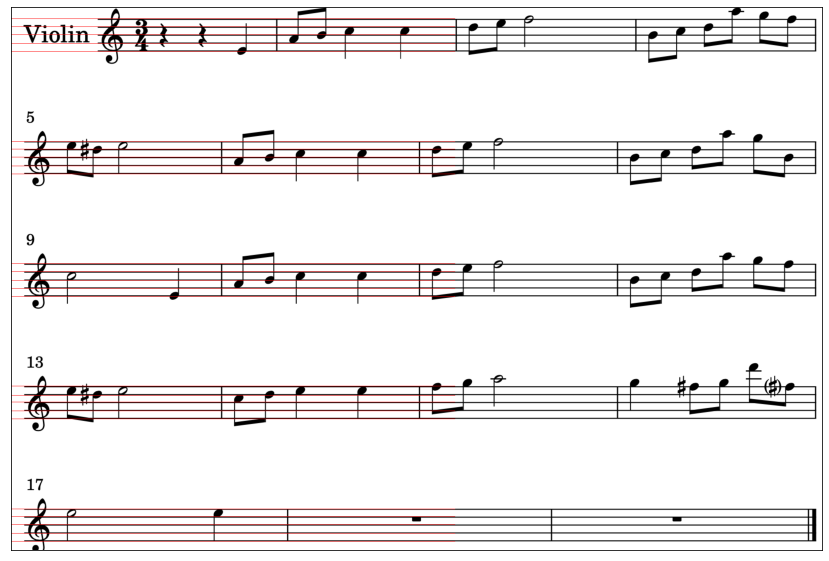

In [65]:
#filename = './Tests/Test0.png'
#filename = './Tests/Test1.png'
#filename = './Tests/Test2.png' 
#filename = './Tests/Test3.png'
filename = './Tests/Test4.png'
img = cv2.imread(filename)
img2 = img.copy()
img_gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY) #grayscaling the image
img_edges = cv2.Canny(img_gray,100,300,apertureSize = 3) #edge detection

threshold = 600 # threshold for detecting lines
img_lines = cv2.HoughLines(img_edges, 1, np.pi/180.0, threshold)

y = []
for line in img_lines:
    y.append(line[0][0])
line_y = []
for ys in y:
    flag = True
    for yp in line_y:
        if (abs(yp - ys) <= 6):
            flag = False
    if (flag):
        line_y.append(ys)
line_y.sort()
if (len(line_y) > 5):
    line_diff = line_y[5] - line_y[0]
else:
    line_diff = (line_y[4] - line_y[0]) * 2

space_diff = line_y[1] - line_y[0]

for y in line_y:
    cv2.line(img2, (0, int(y)), (1000, int(y)), (255,0 ,0))
## until now, all the lines are found and filtered and saved in liney 
imshow(img2)

## Template Detection

In [66]:
def get_template(path):
    return cv2.cvtColor(cv2.imread(path),cv2.COLOR_BGR2GRAY)
note_templates = np.array(([get_template('./templates/1-semibreve.png')], [get_template('./templates/2-minim-down.png'), get_template('./templates/2-minim-down-line.png')],
                          [get_template('./templates/2-minim-up.png'), get_template('./templates/2-minim-up-line.png')],
                          get_template('./templates/3-crotchet-up.png'),get_template('./templates/3-crotchet-up-line.png'), get_template('./templates/3-crotchet-down.png'), get_template('./templates/3-crotchet-down-line.png'),
                          get_template('./templates/bemol.png'),
                          [get_template('./templates/diesis.png'), get_template('./templates/diesis_line.png'), get_template('./templates/diesis_line_1.png')]))
#0-semibreve
#1-minim-downs
#2-minim-ups
#3,4-crotchet-up
#5,6-crotchet-down
#7-bemol
#8-diesis

### Note Detector Functions
The functions below are used to detect different type of notes and their positions using template matching

In [67]:
def crotchet_detector(img_gray):
    crotchets = []
    #First type of crotchets
    res_crotchup = cv2.matchTemplate(img_gray,note_templates[3],cv2.TM_CCOEFF_NORMED)
    width, height = note_templates[3].shape[::-1]
    locationy, locationx = np.where(res_crotchup>=0.85) #finds the points
    for point in zip(locationx, locationy):
        crotchets.append([point[0] + int(width/2), point[1] + int(height * 7 / 8)])
    
    #second type of crotchets
    res_crotchup = cv2.matchTemplate(img_gray,note_templates[4],cv2.TM_CCOEFF_NORMED)
    width, height = note_templates[4].shape[::-1]
    locationy, locationx = np.where(res_crotchup>=0.90) #finds the points
    for point in zip(locationx, locationy):
        crotchets.append([point[0] + int(width/2), point[1] + int(height * 7 / 8)])
    
    #Third type of crotchets
    res_crotchdown = cv2.matchTemplate(img_gray,note_templates[5],cv2.TM_CCOEFF_NORMED)
    width, height = note_templates[5].shape[::-1]
    locationy, locationx = np.where(res_crotchdown>=0.90) #finds the points
    for point in zip(locationx, locationy):
        crotchets.append([point[0] + int(width/2), point[1] + int(height * 1 / 8)])
        
    #Forth type of crotchets
    res_crotchdown = cv2.matchTemplate(img_gray,note_templates[6],cv2.TM_CCOEFF_NORMED)
    width, height = note_templates[6].shape[::-1]
    locationy, locationx = np.where(res_crotchdown>=0.90) #finds the points
    for point in zip(locationx, locationy):
        crotchets.append([point[0] + int(width/2), point[1] + int(height * 1 / 8)])
    
    return crotchets

def minim_detector(img_gray):
    minims = []
    #First type of minims
    res_minimup = cv2.matchTemplate(img_gray,note_templates[2][0],cv2.TM_CCOEFF_NORMED)
    width, height = note_templates[2][0].shape[::-1]
    locationy, locationx = np.where(res_minimup>=0.85) #finds the points
    for point in zip(locationx, locationy):
        minims.append([point[0] + int(width/2), point[1] + int(height * 7 / 8)])
    
    #second type of minims
    res_minimup = cv2.matchTemplate(img_gray,note_templates[2][1],cv2.TM_CCOEFF_NORMED)
    width, height = note_templates[2][1].shape[::-1]
    locationy, locationx = np.where(res_minimup>=0.90) #finds the points
    for point in zip(locationx, locationy):
        minims.append([point[0] + int(width/2), point[1] + int(height * 7 / 8)])
    
    #Third type of minims
    res_minimdown = cv2.matchTemplate(img_gray,note_templates[1][0],cv2.TM_CCOEFF_NORMED)
    width, height = note_templates[1][0].shape[::-1]
    locationy, locationx = np.where(res_minimdown>=0.90) #finds the points
    for point in zip(locationx, locationy):
        minims.append([point[0] + int(width/2), point[1] + int(height * 1 / 8)])
        
    #Forth type of minims
    res_minimdown = cv2.matchTemplate(img_gray,note_templates[1][1],cv2.TM_CCOEFF_NORMED)
    width, height = note_templates[1][1].shape[::-1]
    locationy, locationx = np.where(res_minimdown>=0.90) #finds the points
    for point in zip(locationx, locationy):
        minims.append([point[0] + int(width/2), point[1] + int(height * 1 / 8)])
    
    return minims

def semibreve_detector(img_gray):
    semibreves = []
    #First Type Of Semibreves
    res_semibreve = cv2.matchTemplate(img_gray,note_templates[0][0],cv2.TM_CCOEFF_NORMED)
    width, height = note_templates[0][0].shape[::-1]
    locationy, locationx = np.where(res_semibreve>=0.90) #finds the points
    for point in zip(locationx, locationy):
        semibreves.append([point[0] + int(width/2), point[1] + int(height/2)])
    return semibreves

def diesis_detector(img_gray):
    diesis = []
    res_diesis = cv2.matchTemplate(img_gray,note_templates[8][0],cv2.TM_CCOEFF_NORMED)
    width, height = note_templates[8][0].shape[::-1]
    locationy, locationx = np.where(res_diesis>=0.85) #finds the points
    for point in zip(locationx, locationy):
        diesis.append([point[0] + int(width/2), point[1] + int(height/2)])
        
    res_diesis = cv2.matchTemplate(img_gray,note_templates[8][1],cv2.TM_CCOEFF_NORMED)
    width, height = note_templates[8][1].shape[::-1]
    locationy, locationx = np.where(res_diesis>=0.85) #finds the points
    for point in zip(locationx, locationy):
        diesis.append([point[0] + int(width/2), point[1] + int(height/2)])
        
    res_diesis = cv2.matchTemplate(img_gray,note_templates[8][2],cv2.TM_CCOEFF_NORMED)
    width, height = note_templates[8][2].shape[::-1]
    locationy, locationx = np.where(res_diesis>=0.85) #finds the points
    for point in zip(locationx, locationy):
        diesis.append([point[0] + int(width/2), point[1] + int(height/2)])
    return diesis
def bemolle_detector(img_gray):
    bemolles = []
    res_bemolle = cv2.matchTemplate(img_gray,note_templates[7],cv2.TM_CCOEFF_NORMED)
    width, height = note_templates[7].shape[::-1]
    locationy, locationx = np.where(res_bemolle>=0.85)
    for point in zip(locationx, locationy):
        bemolles.append([point[0] + int(width/2), point[1] + int(height * 3 / 4)])
    return bemolles

crotchets: 27
minims: 8
semibreves: 0
diesis: 4
bemolles: 0


 Total notes: 35


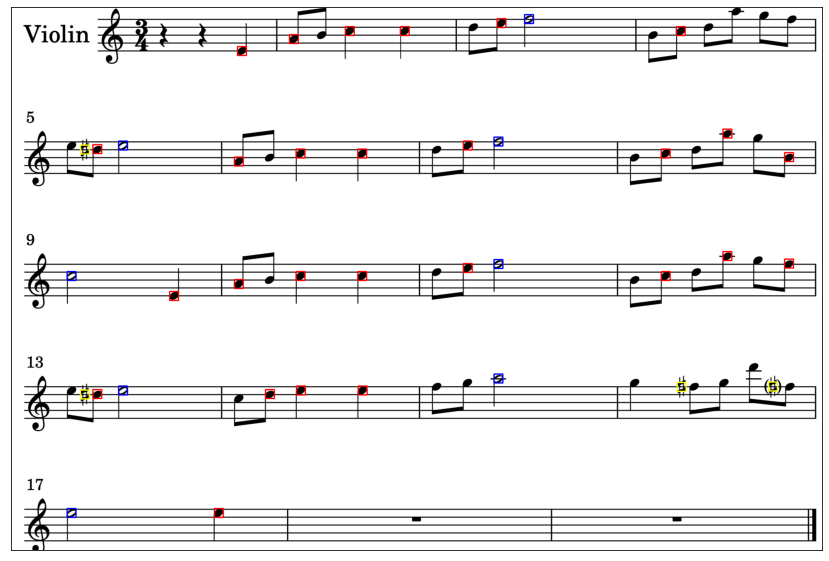

In [68]:
img3 = img.copy()
crotchets = crotchet_detector(img_gray)
minims = minim_detector(img_gray)
semibreves = semibreve_detector(img_gray)
diesis = diesis_detector(img_gray)
bemolles = bemolle_detector(img_gray)

crotchets_filtered = filter_list(crotchets)
minims_filtered = filter_list(minims)
semibreves_filtered = filter_list(semibreves)
diesis_filtered = filter_list(diesis)
bemolles_filtered = filter_list(bemolles)

# Adding the beats
notes = []
for crotchet in crotchets_filtered:
    notes.append([crotchet[0], crotchet[1], 3])
for minims in minims_filtered:
    notes.append([minims[0], minims[1], 2])
for semibreve in semibreves_filtered:
    notes.append([semibreve[0], semibreve[1], 1])
    
print("crotchets: " + str(len(crotchets_filtered)))
print("minims: " + str(len(minims_filtered)))
print("semibreves: " + str(len(semibreves_filtered)))
print("diesis: " + str(len(diesis_filtered)))
print("bemolles: " + str(len(bemolles_filtered)))
print("\n\n Total notes: " + str(len(notes)))

for points in crotchets_filtered:
    cv2.rectangle(img3, (points[0]-10, points[1]-10), (points[0] + 10, points[1]+10), (255,0,0), 2)
for points in minims_filtered:
    cv2.rectangle(img3, (points[0]-10, points[1]-10), (points[0] + 10, points[1]+10), (0,0,255), 2)
for points in semibreves_filtered:
    cv2.rectangle(img3, (points[0]-10, points[1]-10), (points[0] + 10, points[1]+10), (0,255,0), 2)
for points in diesis_filtered:
    cv2.rectangle(img3, (points[0]-10, points[1]-10), (points[0] + 10, points[1]+10), (255,255,0), 2)
for points in bemolles_filtered:
    cv2.rectangle(img3, (points[0]-10, points[1]-10), (points[0] + 10, points[1]+10), (0,255,255), 2)
imshow(img3)

## Sorting 

In [69]:
def sort_by_line(notes):
    sorted_notes = []
    for i in range(int(len(line_y)/5)):
        for note in notes:
            if (find_line(note) == i):
                sorted_notes.append(note)
    return sorted_notes
                
notes.sort()
sorted_notes = sort_by_line(notes)

## Finding the sound of a note

In [70]:
def find_note_sound(note):
    y = note[1]
    notes_line = find_line(note)
    line_base = line_y[notes_line * 5]
    y_diff = y - line_base + space_diff//4
    note_line = y_diff//(space_diff//2)
    is_diesis = has_diesis(note)
    is_bemolle = has_bemolle(note)
    sound = find_sound(note_line)
    if (is_diesis):
        if (sound[0] == 2):
            sound[1] += 1
        if (sound[0] == 11):
            sound[0] = -1
        sound[0] += 1
    if (is_bemolle):
        if (sound[0] == 3):
            sound[1] -= 1
        if (sound[0] == 0):
            sound[0] = 12
        sound[0] -= 1
    #print(str(is_diesis) + ',  ' + str(is_bemolle))
    #print('\n')
    return [sound[0], sound[1], note[2]]

def has_diesis(note):
    for dies in diesis_filtered :
        if (abs(dies[1] - note[1]) < space_diff//4) and ((note[0] - dies[0]) > 0) and ((note[0] - dies[0]) < (space_diff * 3)) :
            return True
    return False

def has_bemolle(note):
    for bemolle in bemolles_filtered :
        if (abs(bemolle[1] - note[1]) < space_diff//4) and ((note[0] - bemolle[0]) > 0) and ((note[0] - bemolle[0]) < (space_diff * 3)) :
            return True
    return False    
    
    
def find_sound(note_line):
    if(note_line == -5): #D6
        if(D_diesis):
            return [6, 6]
        return [5, 6]
    elif (note_line == -4): #C6
        #if(C_diesis):
        #    return [4, 6]
        return [3, 6]
    elif (note_line == -3): #B5
        return [2, 5]
    elif (note_line == -2): #A5
        #if(A_diesis):
        #    return [1, 5]
        #elif(A_bemolle):
        #    return [11, 5]
        return [0, 5] 
    elif (note_line == -1): #G5
        #if(G_diesis):
        #    return [11, 5]
        return [10, 5]
    elif (note_line == 0): #F5
        #if(F_diesis):
        #    return [9, 5]
        return [8, 5]
    elif (note_line == 1): #E5
        return [7, 5]
    elif (note_line == 2): #D5
        #if(D_diesis):
        #   return [6, 5]
        return [5, 5]
    elif (note_line == 3): #C5
        #if(C_diesis):
        #    return [4, 5]
        return [3, 5]
    elif (note_line == 4): #B4
        return [2, 4]
    elif (note_line == 5): #A4
        #if(A_diesis):
        #    return [1, 4]
        return [0, 4]
    elif (note_line == 6): #G4
        #if(G_diesis):
        #    return [11, 4]
        return [10, 4]
    elif (note_line == 7): #F4
        #if(F_diesis):
        #    return [9, 4]
        return [8, 4]
    elif (note_line == 8): #E4
        return [7, 4]
    elif (note_line == 9): #D4
        #if(D_diesis):
        #   return [6, 4]
        return [5, 4]
    elif (note_line == 10): #C4
        #if(C_diesis):
        #   return [4, 4]
        return [3, 4]
    elif (note_line == 11): #B3
        return [2, 3]
    elif (note_line == 12): #A3
        #if(A_diesis):
        #    return [1, 3]
        return [0, 3]
    elif (note_line == 13): #G3
        #if(G_diesis):
        #    return [11, 3]
        return [10, 3]
    

In [71]:
def find_notes(notes):
    note_sounds = []
    for note in notes:
        note_sounds.append(find_note_sound(note))
    return note_sounds


## Playing the music

In [72]:
music = find_notes(sorted_notes)

In [73]:
fs1 = 44100
y = get_music(music, fs1)
sd.play(y, fs1)

In [74]:
savename = './results' + filename[7:13] + '.mp3'
write_mp3(savename, fs1, y, True)